# Summer Topicals 2019 Lab instrumentation demo (lightlab package)

This demo will teach you how to use _lightlab_ to communicate with instruments in your lab.

In this example, we teach you step-by-step how to connect to an instrument that provides a [TCP/IP socket interface][1]). There are many examples of instruments like that, from providers like Keysight, Tektronix etc. Older instruments won't have the same features but will probably have GPIB, which can be interfaced via TCP/IP via hardware like [Prologix GPIB-Ethernet][2] or [National Instruments GPIB-ENET][3].

[1]: https://en.wikipedia.org/wiki/Network_socket
[2]: http://prologix.biz/gpib-ethernet-controller.html
[3]: http://www.ni.com/en-us/support/model.gpib-enet-1000.html



First, in order to communicate with an instrument, we need what is called a _driver_. Lightlab already has [many drivers][drivers] implemented, but here we will create a new one. This driver will belong to a class of _Source Meters_ ([lightlab.laboratory.instruments.bases.SourceMeter][sourcemeter]), which must implement 9 essential methods: `['startup', 'setCurrent', 'getCurrent', 'measVoltage', 'setProtectionVoltage', 'protectionVoltage', 'setProtectionCurrent', 'protectionCurrent', 'enable']`. Below I have written a basic driver for this demo current source.

[drivers]: https://lightlab.readthedocs.io/en/master/API/lightlab.equipment.lab_instruments.html
[sourcemeter]: https://lightlab.readthedocs.io/en/master/API/lightlab.laboratory.instruments.interfaces.html#lightlab.laboratory.instruments.interfaces.SourceMeter

In the fictitious Demo Current Source manual, you see they provide some commands, like `ENABLE 1/0` to enable or disable the current source, or `CURR 0.2` to set the current to 0.2 amps or `VOLT?` to measure voltage drop across terminals. With this information, you should be able to quickly write a driver below. (This entire demo took me only a couple of hours to prepare).

In [1]:
from lightlab.laboratory.instruments import SourceMeter
from sumtopdemo import TCPInstrumentDriver


class DemoCurrentSource(TCPInstrumentDriver):
    '''Demo source meter connected to a diode.
    
    Written by @thomaslima for the lab hackaton in Summer Topicals 2019.
    '''
    instrument_category = SourceMeter
    
    def __init__(self, name='Demo SourceMeter', address=None):
        super().__init__(name, address)
    
    def startup(self):
        self.write('STARTUP')

    def setCurrent(self, currAmps):
        self.write('CURR {}'.format(currAmps))

    def getCurrent(self):
        return self.query('CURR?')

    def measVoltage(self):
        return float(self.query('VOLT?'))

    def setProtectionVoltage(self, protectionVoltage):
        return self.write('PROTVOLT {}'.format(protectionVoltage))

    @property
    def protectionVoltage(self):
        return self.query('PROTVOLT?')

    def setProtectionCurrent(self, protectionCurrent):
        return self.write('PROTCURR {}'.format(protectionCurrent))

    @property
    def protectionCurrent(self):
        return self.query('PROTCURR?')

    def enable(self, enabled):
        if enabled is True:
            self.write('ENABLE 1')
        else:
            self.write('ENABLE 0')

In [2]:
# Here, zeus.local is the hostname of my computer.
cs = DemoCurrentSource(address='TCPIP0::zeus.local::80::SOCKET')
# cs = DemoCurrentSource(address='TCPIP0::ip_address_of_presenter::80::SOCKET')

# if serving from your own computer with python server.py:
cs = DemoCurrentSource(address='TCPIP0::0.0.0.0::80::SOCKET')

Now, we assume that this current source is connected to a diode. Write code below using the methods of `DemoCurrentSource` that applies a current of 0.1 A to the diode and measures the voltage drop in the instrument. 

In [3]:
cs.setProtectionVoltage(3)
cs.setCurrent(0.1)
cs.enable(True)
print(cs.measVoltage())
cs.enable(False)

0.7926313311881847


So let's write a for loop to get an I-V trace. First let's do a quick and dirty diode plot, then we will use another sophisticated tool in lightlab, called the `Sweeper`. Click [here for a full explanation and tutorial](https://lightlab.readthedocs.io/en/master/_static/tutorials/sweeps/sweeps.html).

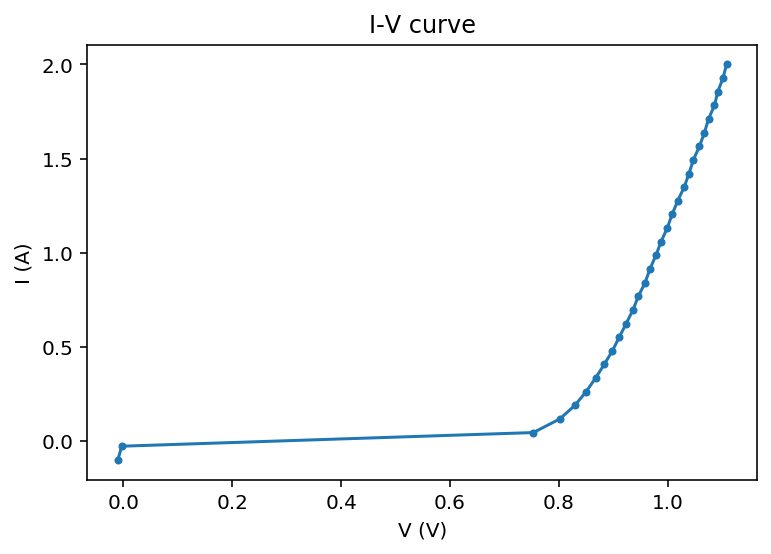

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# make an array of 30 numbers between -0.1 and 0.5.
curr_linspace = np.linspace(-0.1, 2, 30)

# make an array like the first but filled with zeroes
volt = np.zeros_like(curr_linspace)

# set protection voltage
cs.setProtectionVoltage(3)
cs.enable(True)
for idx, curr in enumerate(curr_linspace):
    cs.setCurrent(curr)
    volt[idx] = cs.measVoltage()
cs.enable(False)

plt.plot(volt, curr_linspace, '.-')
plt.title('I-V curve')
plt.ylabel('I (A)')
plt.xlabel('V (V)')
plt.show()

Same thing but with the sweeper. Notice that we will do it in two steps. First we logically program the sweeper with its definitions, then we execute in the following cell. This becomes very useful for more complex or more repetitive sweeps.

In [5]:
from lightlab.util.sweep import NdSweeper

# defining the sweep (3 lines)
IV_sweeper = NdSweeper()
IV_sweeper.addActuation('current', cs.setCurrent, np.linspace(-0.2, 0.4, 30))
IV_sweeper.addMeasurement('voltage', cs.measVoltage)
IV_sweeper.setMonitorOptions(stdoutPrint=False, livePlot=True)

{'livePlot': True, 'plotEvery': 1, 'stdoutPrint': False, 'runServer': False}

Saving to file: /Users/tlima/02GitProjects/sumtop-2019-lightlab-demo/data/IV_sweep_1.pkl


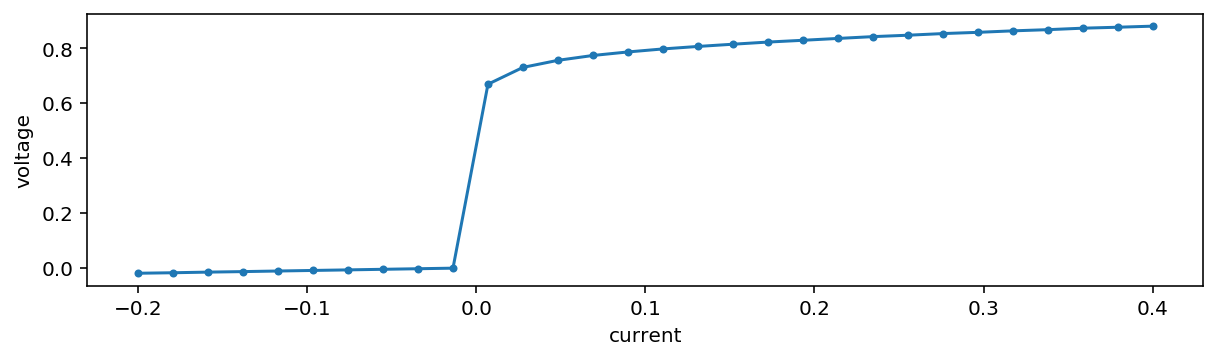

In [6]:
# Gathering data
# # First, prepare your instruments
cs.setProtectionVoltage(3)
cs.enable(True)

# # Second, run the sweep. Make sure you use a try...except...finally statement to catch 
#   any errors and shut down your experiment properly!
try:
    IV_sweeper.gather()
    IV_sweeper.saveObj('IV_sweep_1')  # saves into a file called IV_sweep_1.pkl
finally:
    # this line runs whether or not the statements inside try throw an error. :)
    cs.enable(False)

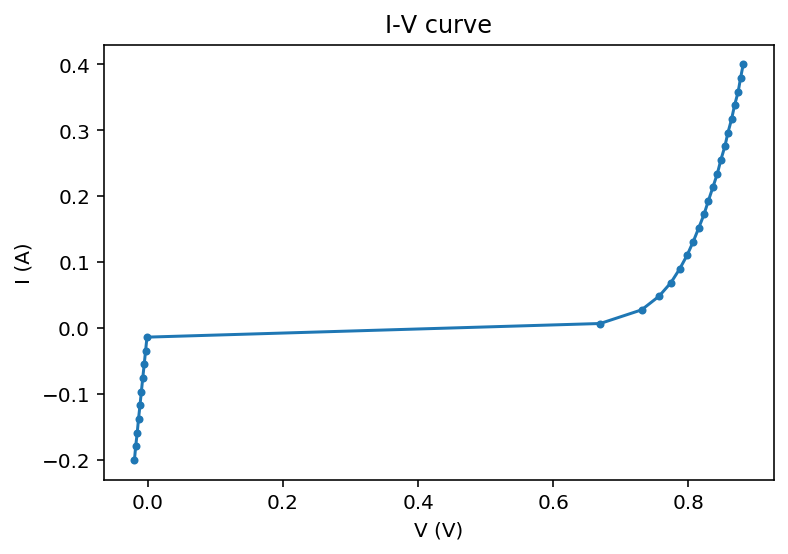

In [7]:
# You can access the collected data easily for replotting or transformation.
# Data are stored in numpy arrays inside IV_sweeper.data
current = IV_sweeper.data['current']
voltage = IV_sweeper.data['voltage']
plt.plot(voltage, current, '.-')
plt.title('I-V curve')
plt.ylabel('I (A)')
plt.xlabel('V (V)')
plt.show()

/Users/tlima/02GitProjects/sumtop-2019-lightlab-demo/venv/lib/python3.6/site-packages/lightlab/util/sweep.py:701: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  actuObj.domain = actData[sliceOneDim]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ce81828>]],
      dtype=object)

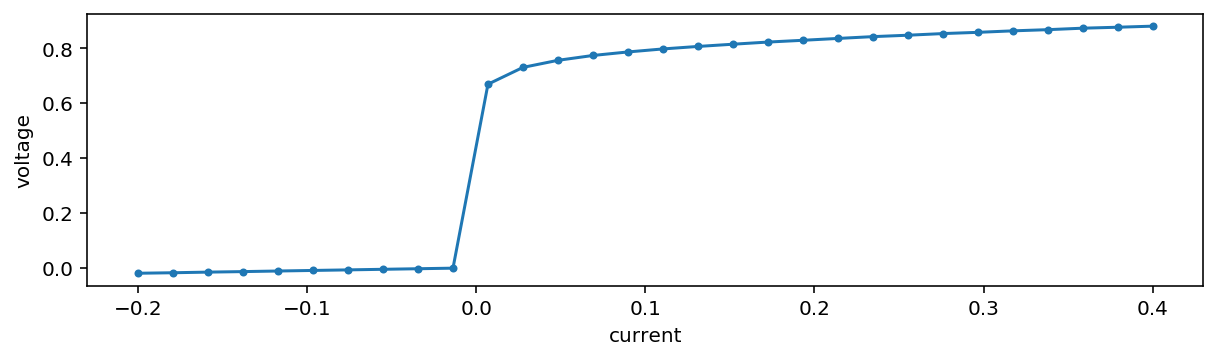

In [8]:
from lightlab.util.sweep import NdSweeper

# You can always reload data from the saved file, in case you 
# no longer have access to the instrument/experiment:
# If you receive a warning, ignore for now

IV_sweeper_recovered = NdSweeper.loadObj('IV_sweep_1', IV_sweeper)
IV_sweeper_recovered.plot()

## That's it for now. 

If you want to learn more or contribute, visit https://lightlab.readthedocs.io and https://github.com/lightwave-lab/lightlab.